# ECG Signal Categorization Using Wavelet Analysis

#### How Does the Wavelet Transform Operate?
It is a linear combination of sine waves with varying frequencies. In contrast, the Wavelet Transform uses a set of functions known as wavelets, each operating at a different scale. A wavelet, meaning "small wave," is a function that oscillates for a brief period and then diminishes.

The figure above demonstrates the key difference between a sine wave and a wavelet. While sine waves extend infinitely in both directions and lack time localization, wavelets are confined to a specific time interval. This localization allows the Wavelet Transform to provide time and frequency information about the signal.
A wavelet is convolved with the signal across its entire length to analyze a signal. Starting at the signal's beginning, the wavelet gradually shifts across time. After analyzing with the original wavelet (called the "mother wavelet"), it is scaled (stretched or compressed), and the process is repeated. This approach captures variations at different time and frequency scales, as shown in the illustration below.

In [ ]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import scipy.io as sio
import scipy

from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier

In [ ]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Each wavelet type has a different shape, smoothness, and compactness, which is helpful for different purposes. Since there are only two mathematical conditions a wavelet has to satisfy, generating a new type of wavelet is easy.

The two mathematical conditions are the so-called normalization and orthogonalization constraints:

A wavelet must have 
* finite energy 
* zero mean

*Finite energy* denotes localization in frequency and time; it is integrable, and the inner product between the wavelet and the signal always exists. The admissibility condition implies a wavelet has zero mean in the time domain, a zero at zero frequency. This is necessary to ensure that it is integrable and that the inverse of the wavelet transform can also be calculated.

In [ ]:
pywt.Wavelet?

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


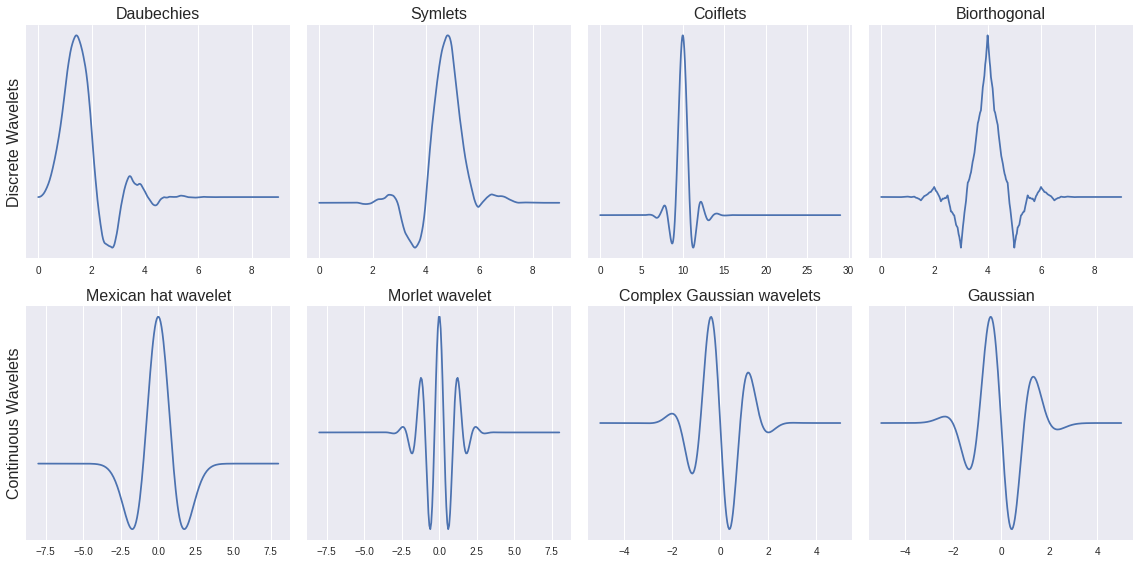

In [ ]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

DWT is implemented as a cascade of high-pass and low-pass filters. This is because filter banks are a very efficient way of splitting a signal into several frequency sub-bands. Below, I will explain the concept behind the filter bank in a simple (and probably oversimplified) way. It is necessary to understand how the wavelet transform works and how it can be used in practical applications. We start with the most miniature scale to apply the DWT on a signal. As we have seen before, small scales correspond with high frequencies. This means that we first analyze high-frequency behaviour. We examine behaviour at around half of the maximum frequency in the second stage, where the scale increases by a factor of two (the frequency lowers by a factor of two). We are examining frequency behaviour at around a quarter of the maximum frequency at the third level, where the scale factor is four. Moreover, this continues until we have reached the maximum decomposition level.

What do we mean by maximum decomposition level?  To understand this, we should also know that at each subsequent stage, the number of samples in the signal is reduced by a factor of two. At lower frequency values, you will need fewer samples to satisfy the Nyquist rate, so there is no need to keep the higher number of samples in the signal; it will only cause the transform to be computationally expensive. Due to this downsampling, at some stage in the process, the number of samples in our signal will become smaller than the length of the wavelet filter, and we will have reached the maximum decomposition level. In the first stage, we split our signal into a low-frequency and a high-frequency part. In the third stage, we split the 0-250 Hz part into 0-125 Hz and 125-250 Hz parts.
This goes on until we have reached the refinement level we need or run out of samples.
We can easily visualize this idea by plotting what happens when we apply the DWT to a chirp signal. A chirp signal is a signal with a dynamic frequency spectrum; the frequency spectrum increases with time. The start of the signal contains low-frequency values, and the end contains high frequencies. This makes it easy to visualize which part of the frequency spectrum is filtered out by looking at the time axis.


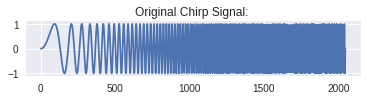

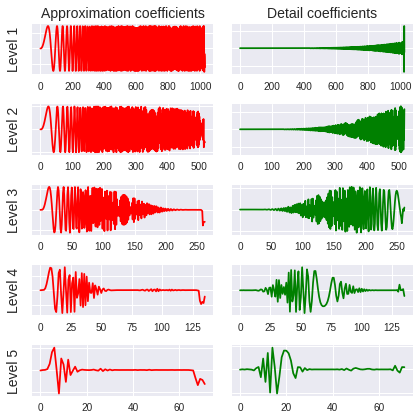

In [ ]:
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [ ]:
chirp_signal.shape

(2048,)

Wavelet Transform Coefficients and Their Significance
The Discrete Wavelet Transform (DWT) provides two essential outputs at each level of decomposition: approximation coefficients and detail coefficients. The example below demonstrates the application of the sym5 wavelet on a chirp signal across levels 1 to 5, alongside a schematic of the high-pass and low-pass filters applied at each stage.

Important Aspects:
Estimated The low-pass filter, also known as an averaging filter, is where the coefficients come from.
They pick up on the signal's low-frequency elements or general trends.
Detail Coefficients: The high-pass filter, often known as the difference filter, provides these.
They record the high-frequency or detailed parts of the signal.

Several Levels of Decomposition:
By applying the DWT recursively to the approximation coefficients from the previous level, we can obtain the wavelet transform for subsequent levels.
Each successive level samples the original signal at half the resolution, effectively down-sampling the signal by a factor of 2.
This hierarchical decomposition allows for efficient signal analysis, enabling both time and frequency localization of features.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft

# Function to plot Wavelet Transform (Power Spectrum)
def plot_wavelet(time, signal, scales, waveletname='cmor', 
                 cmap=plt.cm.seismic, title='Wavelet Transform (Power Spectrum)',
                 ylabel='Period (years)', xlabel='Time'):
    """
    Plots the Wavelet Transform (Power Spectrum) of a given signal.
    """
    dt = time[1] - time[0]  # Time step
    coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)
    power = (np.abs(coefficients)) ** 2  # Compute power spectrum
    period = 1. / frequencies  # Convert frequencies to periods

    # Define log scale for contours
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), levels=contourlevels, extend='both', cmap=cmap)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)

    # Customize y-axis (log scale for periods)
    yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels([f'{int(tick)}' for tick in yticks])
    ax.invert_yaxis()  # Invert y-axis for wavelet representation
    ax.set_ylim(ax.get_ylim()[0], -1)

    # Add a colorbar
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

# Function to compute averaged values over specified intervals
def get_ave_values(xvalues, yvalues, n=5):
    """
    Computes averaged values of x and y over n intervals.
    """
    signal_length = len(xvalues)
    padding_length = (n - signal_length % n) if signal_length % n != 0 else 0

    # Pad arrays if necessary
    xarr = np.pad(xvalues, (0, padding_length), constant_values=np.nan)
    yarr = np.pad(yvalues, (0, padding_length), constant_values=np.nan)

    # Reshape and compute averages
    x_reshaped = xarr.reshape(-1, n)
    y_reshaped = yarr.reshape(-1, n)
    x_ave = x_reshaped[:, 0]  # Take the first value in each interval
    y_ave = np.nanmean(y_reshaped, axis=1)  # Compute mean while ignoring NaNs

    return x_ave, y_ave

# Function to plot signal and its time-averaged version
def plot_signal_plus_average(time, signal, average_over=5):
    """
    Plots the signal alongside its time-averaged version.
    """
    time_ave, signal_ave = get_ave_values(time, signal, average_over)

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(time, signal, label='Signal')
    ax.plot(time_ave, signal_ave, label=f'Time Average (n={average_over})', linestyle='--', color='orange')
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()

# Function to compute FFT values and frequencies
def get_fft_values(y_values, T, N):
    """
    Computes the FFT values and corresponding frequencies.
    """
    f_values = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)  # Frequency axis
    fft_values = 2.0 / N * np.abs(fft(y_values)[:N // 2])  # FFT amplitudes
    return f_values, fft_values

# Function to plot Fourier Transform and Power Spectrum
def plot_fft_plus_power(time, signal):
    """
    Plots the Fourier Transform and its power spectrum for a given signal.
    """
    dt = time[1] - time[0]  # Time step
    N = len(signal)  # Number of samples
    fs = 1 / dt  # Sampling frequency

    # Compute FFT and its power spectrum
    variance = np.std(signal) ** 2
    f_values, fft_values = get_fft_values(signal, dt, N)
    fft_power = variance * fft_values ** 2  # Compute power spectrum

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.set_title('Fourier Transform + Power Spectrum', fontsize=18)
    ax.legend()
    plt.show()


In [ ]:

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset, header=None)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
scales = np.arange(1, 128)

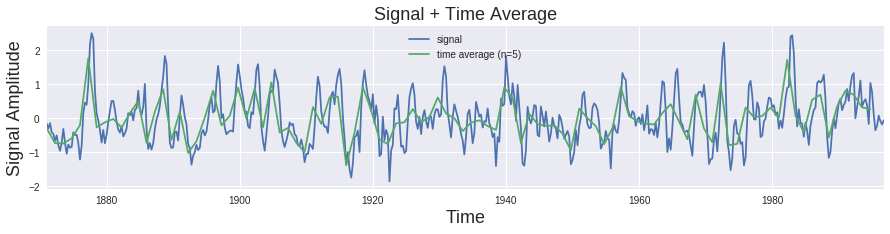

In [ ]:

plot_signal_plus_average(time, signal)

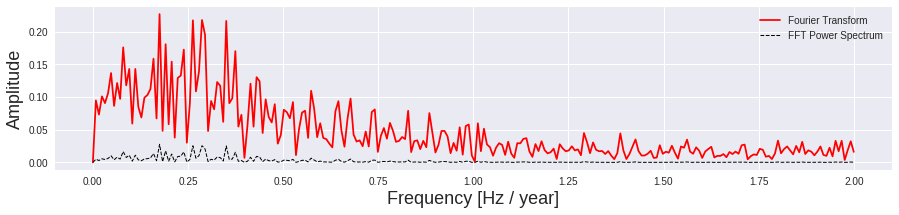

In [ ]:

plot_fft_plus_power(time, signal)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


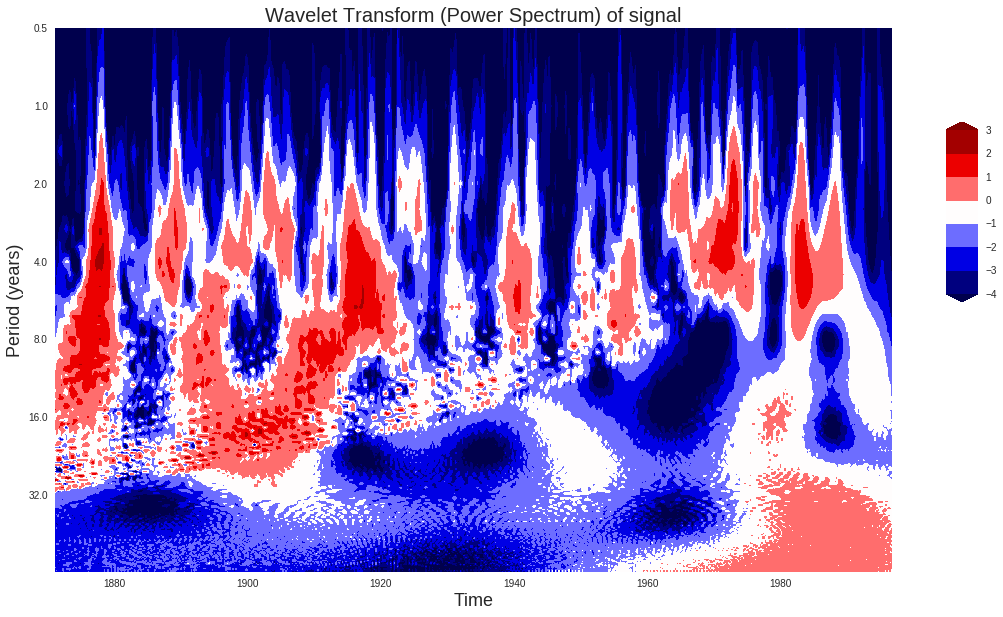

In [ ]:

plot_wavelet(time, signal, scales)

## Classification of signals using the CWT and CNN
we have seen that the wavelet transform of a 1D signal results in a 2D scaleogram, which contains a lot more information than just the time series or the Fourier Transform. We have seen that when applied to the el-Nino dataset, it can tell us the period of the most considerable oscillations, when these oscillations were present, and when they were not.

Such a scaleogram can be used to understand a system's dynamic behaviour better and to distinguish different types of signals produced by a system from each other.
If you record a signal while walking up or down the stairs, the scaleograms will look different. ECG measurements of people with a healthy heart will have different scaleograms than ECG measurements of people with arrhythmia. Alternatively, measurements on a bearing, motor, rotor, ventilator, etc, are taken when it is faulty vs. when it is not faulty. The possibilities are limitless!

So, by looking at the scaleograms, we can distinguish a broken motor from a working one, a healthy person from a sick one, a person walking up the stairs from a person walking down the stairs, etc. However, if you are as lazy as me, you probably do not want to manually sift through thousands of scaleograms. One way to automate this process is to build a Convolutional Neural Network, which can automatically detect the class each scaleogram belongs to and classify them accordingly.

In [ ]:
# Raw Data
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
! unzip HAPT" "Data" "Set.zip

In [ ]:
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
! unzip HAPT" "Data" "Set.zip

The raw data has three main signal types: total acceleration, body acceleration, and body gyroscope. Each has three axes of data. This means that there are nine variables for each time step.

Additionally, every data series has been divided into 128-time increments or overlapping windows of 2.65 seconds of data. The preceding section's engineering feature windows (rows) match these data windows.

This indicates that a single row of data has 1,152 elements (128 * 9). There is probably some redundant data, less than twice as large as the 561 element vectors in the preceding section.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d uciml/human-activity-recognition-with-smartphones
! unzip human-activity-recognition-with-smartphones.zip

 36% 9.00M/25.0M [00:00<00:00, 24.9MB/s]
100% 25.0M/25.0M [00:00<00:00, 50.8MB/s]
Archive:  human-activity-recognition-with-smartphones.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

data = pd.concat([train, test], axis=0).reset_index(drop=True)


In [ ]:
labels = data.iloc[:,-1]
data=data.drop(['subject','Activity'], axis=1)

In [ ]:
data.head()

## ECG classifier

In [ ]:
! wget https://github.com/mathworks/physionet_ECG_data/raw/master/ECGData.zip
! unzip ECGData.zip

In [ ]:
import scipy.io as sio
import scipy
from collections import defaultdict, Counter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
from collections import Counter


In [ ]:
data=sio.loadmat('ECGData.mat')

In [ ]:
ecg_signals= pd.DataFrame(data['ECGData'][0][0][0])
ecg_labels= pd.Series(np.array(list(map(lambda x: str(x[0]), 
                                        np.squeeze(data['ECGData'][0][0][1])))), name='labels').astype('category')

ecg_data=pd.concat([ecg_labels, ecg_signals],axis=1)


In [ ]:

ecg_data.tail()

,labels,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
157,NSR,-0.075,-0.165,-0.225,-0.175,-0.225,-0.225,-0.215,-0.185,-0.235,...,-0.165,-0.265,-0.505,-0.315,0.575,1.775,1.315,-0.195,-0.725,-0.495
158,NSR,-0.185,-0.155,-0.145,-0.135,-0.105,-0.095,-0.095,-0.065,-0.055,...,0.105,0.105,0.155,0.125,0.175,0.155,0.185,0.225,0.225,0.155
159,NSR,-0.355,-0.355,-0.345,-0.335,-0.335,-0.345,-0.345,-0.375,-0.365,...,-0.125,-0.175,-0.225,-0.235,-0.275,-0.315,-0.355,-0.335,-0.315,-0.315
160,NSR,-0.275,-0.245,-0.285,-0.265,-0.235,-0.215,-0.165,-0.165,-0.145,...,0.015,-0.095,-0.075,-0.105,-0.145,-0.165,-0.165,-0.205,-0.145,-0.165
161,NSR,0.125,0.005,0.025,0.065,-0.085,0.005,-0.065,-0.015,-0.035,...,-0.245,-0.225,-0.245,-0.275,-0.295,-0.275,-0.275,-0.225,-0.275,-0.205


In [ ]:
def plot_ecg_signal(arr_type):
    
    
    signal=ecg_data[ecg_data['labels']==arr_type].iloc[0,1:]
    time=np.arange(0,len(signal),1)
    
    plt.plot(time[0:500],signal[0:500])
    plt.xlabel('Time')
    plt.ylabel('Amplitud')
    plt.title(f'{arr_type}')

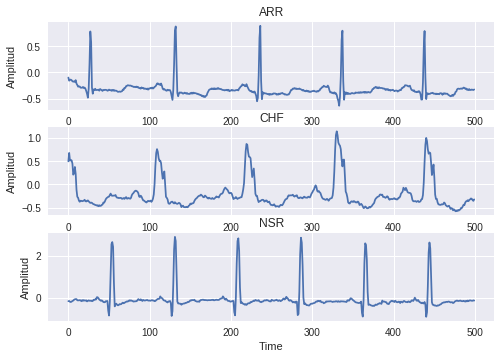

In [ ]:
plt.figure()
plt.subplot(311)
plot_ecg_signal('ARR')
plt.subplot(312)
plot_ecg_signal('CHF')
plt.subplot(313)
plot_ecg_signal('NSR')

### Classifier with Raw data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ecg_signals, ecg_labels, random_state=3)

In [ ]:
lgbm = LGBMClassifier(n_estimators=1000, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(y_test, y_pred))

Accuracy on testset:	0.8049

              precision    recall  f1-score   support

         ARR       0.82      0.88      0.85        26
         CHF       0.50      0.25      0.33         4
         NSR       0.82      0.82      0.82        11

   micro avg       0.80      0.80      0.80        41
   macro avg       0.71      0.65      0.67        41
weighted avg       0.79      0.80      0.79        41



### Classifier with PCA

In [ ]:
scl = StandardScaler()
pca_data = scl.fit_transform(ecg_signals)

pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(pca_data)

enc = LabelEncoder()
label_encoded = enc.fit_transform(ecg_labels)

X_train, X_test, y_train, y_test = train_test_split(pca_data, label_encoded, random_state=3)
print(X_train.shape)

(121, 71)


In [ ]:
lgbm = LGBMClassifier(n_estimators=2000, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(y_test, y_pred))

Accuracy on testset:	0.8049

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.33      0.50      0.40         4
           2       1.00      0.82      0.90        11

   micro avg       0.80      0.80      0.80        41
   macro avg       0.73      0.72      0.72        41
weighted avg       0.84      0.80      0.82        41



### Feature engineering

In [ ]:
dict_ecg_data = defaultdict(list)
for ii, label in enumerate(ecg_labels.values):
    dict_ecg_data[label].append(ecg_signals.values[ii])

In [ ]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics
  
def get_ecg_features(ecg_data, ecg_labels, waveletname):
    list_features = []
    list_unique_labels = list(set(ecg_labels))
    list_labels = [list_unique_labels.index(elem) for elem in ecg_labels]
    for signal in ecg_data:
        list_coeff = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
    return list_features, list_labels
  
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

In [ ]:
list_labels = []
list_features = []
for k, v in dict_ecg_data.items():
    yval = list(dict_ecg_data.keys()).index(k)
    for signal in v:
        features = []
        list_labels.append(yval)
        list_coeff = pywt.wavedec(signal, 'sym5')
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
df = pd.DataFrame(list_features)
ycol = 'y'
xcols = list(range(df.shape[1]))
df.loc[:,ycol] = list_labels

df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df, ycol, xcols, ratio = 0.5)
print(X_train.shape)

(99, 156)


#### Gradient Boosting with Feature engineering 96.8% acc  

In [ ]:
cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train, Y_train)
train_score = cls.score(X_train, Y_train)
test_score = cls.score(X_test, Y_test)
print("The Train Score is {}".format(train_score))
print("The Test Score is {}".format(test_score))

y_pred=GradientBoostingClassifier.predict(cls, X_test)
score = accuracy_score(y_true=Y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(Y_test, y_pred))

The Train Score is 1.0
The Test Score is 0.9523809523809523
Accuracy on testset:	0.9524

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      0.67      0.80         9
           2       1.00      1.00      1.00        12

   micro avg       0.95      0.95      0.95        63
   macro avg       0.98      0.89      0.92        63
weighted avg       0.96      0.95      0.95        63



#### LGBM with feature engineering 98% acc...

In [ ]:
%time
lgbm = LGBMClassifier(n_estimators=2000, random_state=3)
lgbm = lgbm.fit(X_train, Y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=Y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(Y_test, y_pred))

Accuracy on testset:	0.9841

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        12

   micro avg       0.98      0.98      0.98        63
   macro avg       0.99      0.96      0.98        63
weighted avg       0.98      0.98      0.98        63

